# Loading images

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision import transforms

from torchsummary import summary
%matplotlib inline

In [2]:
%%time
#labels with the same order
train_images = []
train_labels = []

test_images = []
test_dict = {}
train_filenames = []
test_filenames = []


labels_df = pd.read_csv('train_onelabel.csv')
labels_dict = labels_df.set_index('image')['class'].to_dict()

for filename in labels_df['image'].values: ##to keep mapping with classes
    train_images.append(Image.open('train_images/'+filename).copy())
    train_labels.append(labels_dict[filename])
    train_filenames.append(filename)
for filename in glob.iglob('test_images' +'/*'):
    image = Image.open(filename).copy()
    test_images.append(image)
    test_filenames.append(filename.replace('test_images/', ''))

CPU times: user 12.1 s, sys: 3.25 s, total: 15.3 s
Wall time: 2min 23s


Average width 73.32110394976037 , Average height: 66.46897207073211


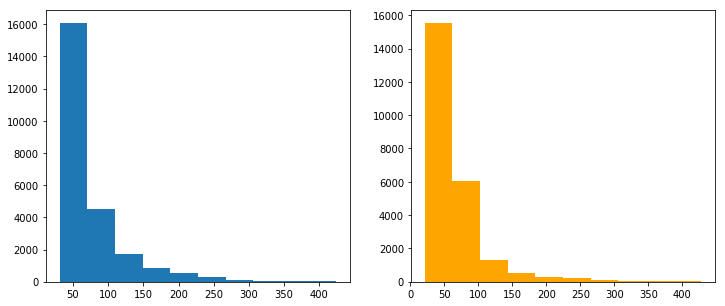

In [5]:
#PIL

widths, heights = [], [] 
sumx, sumy = 0, 0
for i in train_images:
    sumx += i.size[0]
    widths.append(i.size[0])
    sumy += i.size[1]
    heights.append(i.size[1])


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(widths)
ax2.hist(heights, color = 'orange')
fig.set_size_inches(12, 5)

avg_width = np.mean(widths)
avg_height = np.mean(heights)
print('Average width {} , Average height: {}'.format(avg_width, avg_height))

In [6]:
class ListsTrainDataset(Dataset):
    def __init__(self, list_of_images, list_of_labels, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
#         super().__init__()
        self.data = list_of_images
        self.labels = np.asarray(list_of_labels).reshape(-1,1)
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        single_image_label = self.labels[index]
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data)

In [7]:
class ListsTestDataset(Dataset):
    def __init__(self, list_of_images, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = list_of_images
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image ONLY
        return img_as_tensor

    def __len__(self):
        return len(self.data)

In [8]:
#Transforms and Dataset Creation
def create_datasets_dataloaders(X_train, y_train, X_test, y_test = None):
    test_transforms = transforms. Compose([
        transforms.CenterCrop(28),
        transforms.ToTensor()
    ])
    train_transforms = transforms. Compose([
        transforms.CenterCrop(28),
        transforms.ToTensor()
    ])
    
    train_dataset = ListsTrainDataset(X_train, y_train, transform = train_transforms)
    if y_test is not None:
        test_dataset = ListsTrainDataset(X_test, y_test, transform = test_transforms)
    else:
        test_dataset = ListsTestDataset(X_test, transform = test_transforms)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)
    return (train_loader, test_loader)

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(50, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            Flatten(),
            nn.Linear(20*7*7, 250),
            nn.ReLU())
        self.fc = nn.Linear(250, 121)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        return out

In [30]:
def train(model, data_loader, num_epochs):
    learning_rate = 0.0005
    batch_size = data_loader.batch_size
    criterion = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate);
    #Training
    history = {'batch': [], 'loss': [], 'accuracy': []}
    for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(data_loader):
                images = Variable(images).cuda()
                labels = Variable(labels).squeeze(1).long().cuda()#.cpu()
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, argmax = torch.max(outputs, 1)
                accuracy_train = (labels == argmax.squeeze()).float().mean()*100
                # Show progress
                if (i+1) % 32 == 0:
                    log = " ".join([
                      "Epoch : %d/%d" % (epoch+1, num_epochs),
                      "Iter : %d/%d" % (i+1, len(data_loader.dataset)//batch_size),
                      "Loss: %.4f" % loss.item(),
                      "Accuracy: %.4f" % accuracy_train])
                    print('\r{}'.format(log), end='')
                    history['batch'].append(i)
                    history['loss'].append(loss.item())
                    history['accuracy'].append(accuracy_train.item())
            print()
    return model

In [ ]:
cnn.eval().cuda()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    labels= labels.squeeze(1)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.float() == labels).sum()
print('Test Accuracy of the model on the 60000 test images: %.4f %%' % (100*correct.item() / total))

In [ ]:
def predict_test_set(model, test_filenames, ):
    predictions = []
    for images in test_loader:
        images = Variable(images).cuda()
        outputs = cnn(images)
        _, prediction = torch.max(outputs.data, 1)
        predictions.extend(prediction.cpu().numpy())
    results_df = pd.DataFrame({'image': test_filenames, 'class': predictions}, columns=['image', 'class'])
    results_df.to_csv('results.csv',sep = ',', index = False)

In [ ]:

x_sample = train_images[:1000]
y_sample = train_labels[:1000]

x_sample[675]

## KFolds

In [32]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=None, shuffle=True)
trained_models = []
for train_indexes, validation_indexes in kf.split(train_images):
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    
    for i in train_indexes:
        X_train.append(train_images[i])
        y_train.append(train_labels[i])
    for j in validation_indexes:
        X_val.append(train_images[j])
        y_val.append(train_labels[j])
    train_loader, test_loader = create_datasets_dataloaders(
        X_train, y_train, X_val, y_val)
    
    #Training
    cnn = CNN().cuda()
#     print(summary(cnn, (1,28,28)))
    trained_model = train(cnn, train_loader, num_epochs=100)
    trained_models.append(trained_model)

Epoch : 1/5 Iter : 576/605 Loss: 2.8555 Accuracy: 31.2500
Epoch : 2/5 Iter : 576/605 Loss: 2.0015 Accuracy: 46.8750
Epoch : 3/5 Iter : 576/605 Loss: 2.2042 Accuracy: 46.8750
Epoch : 4/5 Iter : 576/605 Loss: 2.2267 Accuracy: 46.8750
Epoch : 5/5 Iter : 576/605 Loss: 1.7001 Accuracy: 59.3750
Epoch : 1/5 Iter : 576/605 Loss: 3.1284 Accuracy: 31.2500
Epoch : 2/5 Iter : 576/605 Loss: 2.2007 Accuracy: 59.3750
Epoch : 3/5 Iter : 576/605 Loss: 2.4296 Accuracy: 40.6250
Epoch : 4/5 Iter : 576/605 Loss: 2.3031 Accuracy: 43.7500
Epoch : 5/5 Iter : 576/605 Loss: 1.6738 Accuracy: 43.7500
Epoch : 1/5 Iter : 576/605 Loss: 2.9217 Accuracy: 28.1250
Epoch : 2/5 Iter : 576/605 Loss: 2.4680 Accuracy: 37.5000
Epoch : 3/5 Iter : 576/605 Loss: 2.7614 Accuracy: 25.0000
Epoch : 4/5 Iter : 576/605 Loss: 2.3855 Accuracy: 31.2500
Epoch : 5/5 Iter : 576/605 Loss: 2.1188 Accuracy: 37.5000
Epoch : 1/5 Iter : 576/605 Loss: 3.4049 Accuracy: 18.7500
Epoch : 2/5 Iter : 576/605 Loss: 2.3893 Accuracy: 37.5000
Epoch : 3/5 It

In [39]:
cnn1 = trained_models[0]
cnn1.fc.weight

Parameter containing:
tensor([[-0.0168, -0.0130,  0.0252,  ...,  0.0460, -0.0444,  0.0676],
        [-0.0317, -0.0941,  0.0557,  ...,  0.0234,  0.0467,  0.0618],
        [-0.3464, -0.0394,  0.0285,  ...,  0.0470, -0.0223, -0.1115],
        ...,
        [-0.1316,  0.0347, -0.0653,  ...,  0.0428,  0.0268, -0.0213],
        [ 0.0074,  0.0450, -0.0466,  ...,  0.0525,  0.0084,  0.0840],
        [-0.0987, -0.0957, -0.0103,  ..., -0.0731, -0.0283, -0.0347]],
       device='cuda:0', requires_grad=True)

In [40]:
cnn2 = trained_models[1]
cnn2.fc.weight

Parameter containing:
tensor([[ 0.0070,  0.0135,  0.0011,  ..., -0.0310, -0.0125, -0.0374],
        [ 0.0209, -0.0459,  0.0046,  ...,  0.0476,  0.0577,  0.0305],
        [-0.0291,  0.0265,  0.0575,  ...,  0.0408,  0.0601,  0.0046],
        ...,
        [-0.0418, -0.0169,  0.0464,  ..., -0.0072,  0.0393, -0.0152],
        [ 0.0230,  0.0071,  0.0051,  ..., -0.0624,  0.0516, -0.0562],
        [-0.0260, -0.0319,  0.0064,  ...,  0.0367,  0.0147,  0.0346]],
       device='cuda:0', requires_grad=True)